# Likelihood computation benchmarks
In this notebook we compare the run time of the various likelihood functions implemented in the recombulator-x module.

In [1]:
import time
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

In [2]:
import recombulatorx
from recombulatorx import compute_family_likelihood
from recombulatorx.testing import generate_processed_family, generate_random_rates

Retrieve the available implementations, which vary depending on the availability of the numba module.

In [3]:
available_implementations = recombulatorx.likelihood.implementations.keys()
available_implementations = [i for i in available_implementations if i != 'direct-loop-numba']
available_implementations

['dynamic', 'direct-loop', 'direct-numpy', 'dynamic-numba']

Define benchmarking parameters, the number of families and the maximum mean time (in seconds) allowed for one family likelihood computation:

In [4]:
max_time = 1
n_fam_I = 100
n_fam_II = 100

In [5]:
time_df_acc = {}
slow_funcs = set()
first_run = True
for n_markers in tqdm(itertools.chain(range(2, 101), range(10**4 - 50, 10**4 + 1))):

    rates = generate_random_rates(n_markers)
    direct_numpy_cache = None        
                
    fams_I = [generate_processed_family(f'FAM_I_{i}', 2, True, *rates) for i in range(n_fam_I)]
    fams_II = [generate_processed_family(f'FAM_II_{i}', 2, False, *rates) for i in range(n_fam_II)]
    time_acc = {}
    if first_run: # run every function once, this is mainly for numba since it needs to compile!
        for impl in available_implementations:
            compute_family_likelihood(fams_I[0], *rates, implementation=impl)
            compute_family_likelihood(fams_II[0], *rates, implementation=impl)
        first_run = False
    
    for fams in fams_I, fams_II:
        for impl in available_implementations:
            for fam in fams:
                ftype = 'type I' if fam.is_mother_phased else 'type II'
                if (impl, ftype) in slow_funcs: continue
                t0 = time.time()
                lh = compute_family_likelihood(fam, *rates, implementation=impl)
                t1 = time.time()
                time_acc[(impl, ftype, fam.fid)] = [lh, t1 - t0]
    if len(time_acc) == 0:
        break
    
    df = pandas.DataFrame(time_acc, index=['Family Likelihood', 'Elapsed Time']).T
    df.index.names = ['Implementation', 'Family Type', 'Family ID']

    # check if any function is taking too long
    mean_dt = df.reset_index().groupby(['Implementation', 'Family Type'])['Elapsed Time'].mean()
    new_slow = set(mean_dt.index[mean_dt > max_time])
    slow_funcs |= new_slow
    if new_slow:
        print('dropped', new_slow, 'at', n_markers, 'markers')
    time_df_acc[n_markers] = df.reset_index()

7it [02:41, 46.61s/it]

dropped {('direct-loop', 'type II')} at 8 markers


11it [11:09, 154.07s/it]

dropped {('direct-numpy', 'type II')} at 12 markers


15it [19:24, 158.04s/it]

dropped {('direct-loop', 'type I')} at 16 markers


16it [21:55, 155.91s/it]

dropped {('dynamic', 'type II')} at 17 markers


19it [27:56, 145.93s/it]

dropped {('direct-numpy', 'type I')} at 20 markers


22it [29:48, 73.04s/it] 

dropped {('dynamic-numba', 'type II')} at 21 markers


150it [41:57, 16.78s/it]


In [6]:
full_df = pandas.concat(time_df_acc, names=['# of markers', 'row']).reset_index('row', drop=True).reset_index()
full_df

,# of markers,Implementation,Family Type,Family ID,Family Likelihood,Elapsed Time
0,2,dynamic,type I,FAM_I_0,0.246767,0.000381
1,2,dynamic,type I,FAM_I_1,0.246767,0.000131
2,2,dynamic,type I,FAM_I_2,0.246768,0.000115
3,2,dynamic,type I,FAM_I_3,0.246767,0.000121
4,2,dynamic,type I,FAM_I_4,0.246770,0.000104
...,...,...,...,...,...,...
38795,10000,dynamic-numba,type I,FAM_I_95,0.000000,0.000519
38796,10000,dynamic-numba,type I,FAM_I_96,0.000000,0.000461
38797,10000,dynamic-numba,type I,FAM_I_97,0.000000,0.000467
38798,10000,dynamic-numba,type I,FAM_I_98,0.000000,0.000394


In [7]:
full_df.to_csv('benchmarks.tsv', index=False, sep='\t')

In [8]:
full_df = pandas.read_csv('benchmarks.tsv', sep='\t')

## Plotting times

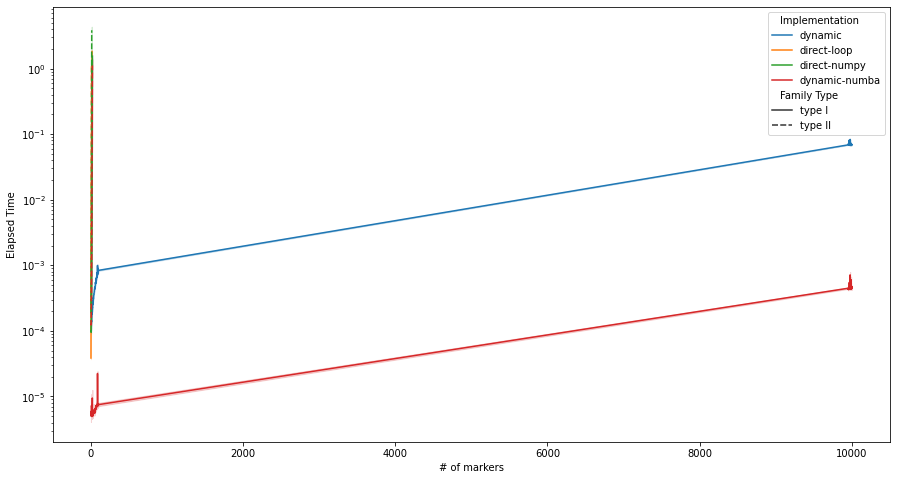

In [9]:
fig = plt.figure(figsize=(15, 8))
seaborn.lineplot(data=full_df, x='# of markers', y='Elapsed Time', hue='Implementation', style='Family Type')
plt.yscale('log')

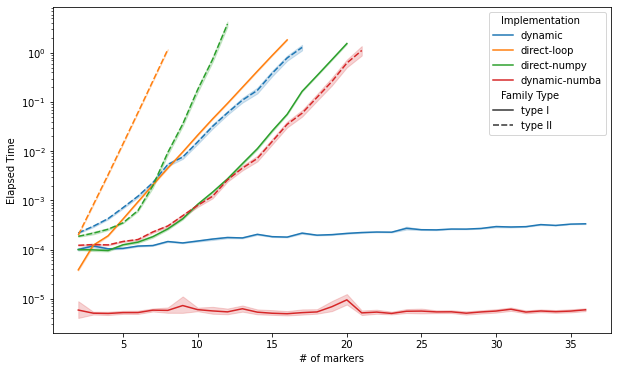

In [10]:
fig = plt.figure(figsize=(10, 6))
seaborn.lineplot(data=full_df.loc[full_df['# of markers'] <= 36], x='# of markers', y='Elapsed Time', hue='Implementation', style='Family Type')
plt.yscale('log')

In [11]:
fig.savefig('likelihood_benchmarks_1-35.pdf')

In [12]:
plot_df = full_df.copy()
plot_df['BLOCK'] = float('nan')
plot_df.loc[plot_df['# of markers'] < 26, 'BLOCK'] = 'LEFT'
plot_df.loc[plot_df['# of markers'] > 100, 'BLOCK'] = 'RIGHT'

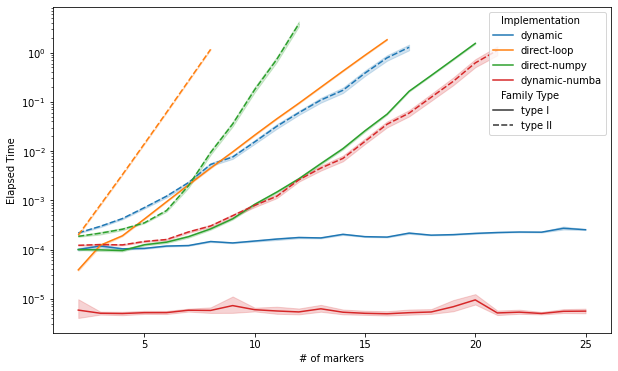

In [13]:
fig = plt.figure(figsize=(10, 6))
seaborn.lineplot(
    data=plot_df.query('BLOCK == "LEFT"'), x='# of markers', y='Elapsed Time', 
    hue='Implementation', style='Family Type', 
)
plt.yscale('log')

In [14]:
fig.savefig('likelihood_benchmarks_1-25.pdf')

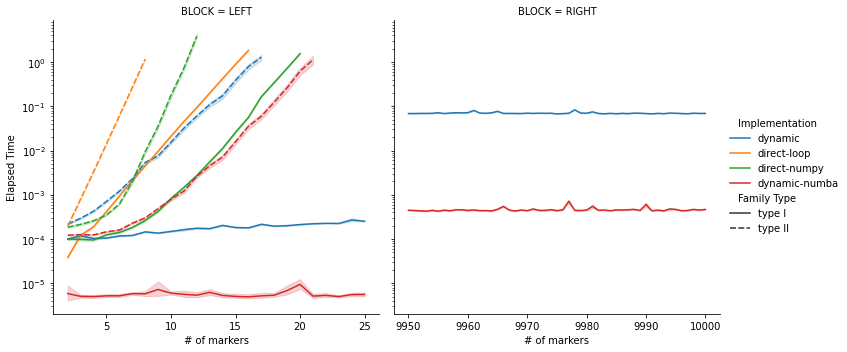

In [15]:
fig = seaborn.relplot(data=plot_df, x='# of markers', y='Elapsed Time', 
                hue='Implementation', style='Family Type', 
                col='BLOCK', kind='line', facet_kws={'sharey': True, 'sharex': False},
)
plt.yscale('log')

In [16]:
fig.savefig('likelihood_benchmarks_split.pdf')